## LSTM for Malayalam

## Malayalam

In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract MFCC features from audio file and pad/truncate to a fixed length
def extract_features(file_path, mfcc_dim=39, max_len=300, hop_length=512, n_fft=480):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=mfcc_dim, hop_length=hop_length, n_fft=n_fft)
    
    # Pad or truncate mfcc to fixed length
    if mfcc.shape[1] > max_len:
        mfcc = mfcc[:, :max_len]
    else:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    
    return mfcc.T  # Transpose to have (time_steps, mfcc_dim)

# Function to load audio files and extract MFCC features
def load_data(data_dir, mfcc_dim=39, max_len=300, hop_length=512, n_fft=480):
    X = []
    y = []
    class_labels = {}
    class_index = 0

    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.wav'):  # Assuming audio files are in .wav format
                file_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                if label not in class_labels:
                    class_labels[label] = class_index
                    class_index += 1
                
                # Extract MFCC features and append to X
                mfcc = extract_features(file_path, mfcc_dim, max_len, hop_length, n_fft)
                X.append(mfcc)
                y.append(label)  # Append the actual label name here
    
    return np.array(X), np.array(y), class_labels

# Example usage
data_dir = '/dist_home/jairam/Malayalam/'  
mfcc_dim = 39  # Updated MFCC coefficients
max_len = 300  # Desired length for MFCC sequences
nb_classes = 4  # Number of classes

# Load data
print('Loading data...')
X, y, class_labels = load_data(data_dir, mfcc_dim, max_len)

# Verify shapes
print('X shape:', X.shape)
print('y shape:', y.shape)
print('Number of classes:', len(class_labels))

# Print unique labels and their numeric values
unique_labels = np.unique(y)
for label in unique_labels:
    print(f"Label: {label}, Numeric Value: {class_labels[label]}")

# Convert labels to numeric format
y_numeric = np.array([class_labels[label] for label in y])

# Ensure labels are within the range 0 to nb_classes-1
assert np.min(y_numeric) >= 0 and np.max(y_numeric) < nb_classes, "Label values are out of range"

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.20, random_state=42)

# Convert class vectors to binary class matrices
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Build the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, stateful=False, input_shape=(max_len, mfcc_dim)))
model.add(LSTM(64, return_sequences=True, stateful=False))
model.add(LSTM(64, stateful=False))
model.add(Dropout(0.25))
model.add(Dense(nb_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Train the model
print("Training...")
history = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_data=(X_test, Y_test))

# Evaluate the model
score = model.evaluate(X_test, Y_test, batch_size=100, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Generate classification report
y_pred_prob = model.predict(X_test, batch_size=32)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=list(class_labels.keys())))


Loading data...
X shape: (8069, 300, 39)
y shape: (8069,)
Number of classes: 4
Label: Kottayam, Numeric Value: 1
Label: Kozhikode, Numeric Value: 0
Label: Thrissur, Numeric Value: 3
Label: Trivandrum, Numeric Value: 2


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 300, 64)        │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 300, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,932 (363.02 KB)

 Trainable params: 92,932 (363.02 KB)

 Non-trainable params: 0 (0.00 B)

Training...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5160 - loss: 1.0201 - val_accuracy: 0.6722 - val_loss: 0.7079
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6927 - loss: 0.6971 - val_accuracy: 0.7497 - val_loss: 0.5740
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7682 - loss: 0.5541 - val_accuracy: 0.7776 - val_loss: 0.5432
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7925 - loss: 0.5044 - val_accuracy: 0.8135 - val_loss: 0.4734
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8379 - loss: 0.4199 - val_accuracy: 0.7999 - val_loss: 0.4889
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8288 - loss: 0.4321 - val_accuracy: 0.8135 - val_loss: 0.4731
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8378 - loss: 0.4264 - val_accuracy: 0.8271 - val_loss: 0.4568
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8739 - loss: 0.3454 - val_accuracy

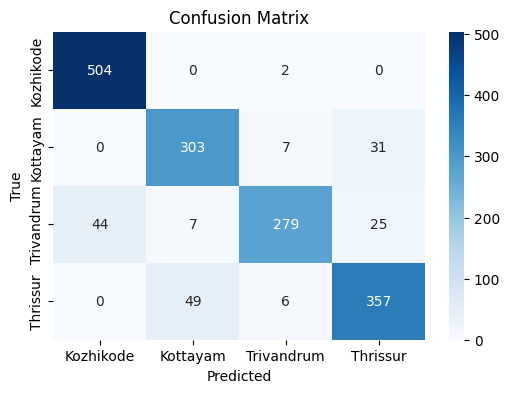

In [3]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## LSTM for Tamil

In [5]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract MFCC features from audio file and pad/truncate to a fixed length
def extract_features(file_path, mfcc_dim=39, max_len=300, hop_length=512, n_fft=480):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=mfcc_dim, hop_length=hop_length, n_fft=n_fft)
    
    # Pad or truncate mfcc to fixed length
    if mfcc.shape[1] > max_len:
        mfcc = mfcc[:, :max_len]
    else:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    
    return mfcc.T  # Transpose to have (time_steps, mfcc_dim)

# Function to load audio files and extract MFCC features
def load_data(data_dir, mfcc_dim=39, max_len=300, hop_length=512, n_fft=480):
    X = []
    y = []
    class_labels = {}
    class_index = 0

    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.wav'):  # Assuming audio files are in .wav format
                file_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                if label not in class_labels:
                    class_labels[label] = class_index
                    class_index += 1
                
                # Extract MFCC features and append to X
                mfcc = extract_features(file_path, mfcc_dim, max_len, hop_length, n_fft)
                X.append(mfcc)
                y.append(label)  # Append the actual label name here
    
    return np.array(X), np.array(y), class_labels

# Example usage
data_dir = '/dist_home/jairam/Tamil/'  
mfcc_dim = 39  # Updated MFCC coefficients
max_len = 300  # Desired length for MFCC sequences
nb_classes = 4  # Number of classes

# Load data
print('Loading data...')
X, y, class_labels = load_data(data_dir, mfcc_dim, max_len)

# Verify shapes
print('X shape:', X.shape)
print('y shape:', y.shape)
print('Number of classes:', len(class_labels))

# Print unique labels and their numeric values
unique_labels = np.unique(y)
for label in unique_labels:
    print(f"Label: {label}, Numeric Value: {class_labels[label]}")

# Convert labels to numeric format
y_numeric = np.array([class_labels[label] for label in y])

# Ensure labels are within the range 0 to nb_classes-1
assert np.min(y_numeric) >= 0 and np.max(y_numeric) < nb_classes, "Label values are out of range"

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.20, random_state=42)

# Convert class vectors to binary class matrices
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Build the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, stateful=False, input_shape=(max_len, mfcc_dim)))
model.add(LSTM(64, return_sequences=True, stateful=False))
model.add(LSTM(64, stateful=False))
model.add(Dropout(0.25))
model.add(Dense(nb_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Train the model
print("Training...")
history = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_data=(X_test, Y_test))

# Evaluate the model
score = model.evaluate(X_test, Y_test, batch_size=100, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Generate classification report
y_pred_prob = model.predict(X_test, batch_size=32)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=list(class_labels.keys())))


Loading data...
X shape: (7435, 300, 39)
y shape: (7435,)
Number of classes: 4
Label: Chennai, Numeric Value: 3
Label: Coimbatore, Numeric Value: 0
Label: Madurai, Numeric Value: 1
Label: Thoothukudi, Numeric Value: 2


/dist_home/common-apps/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 300, 64)        │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 300, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,932 (363.02 KB)

 Trainable params: 92,932 (363.02 KB)

 Non-trainable params: 0 (0.00 B)

Training...
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5111 - loss: 0.9532 - val_accuracy: 0.6590 - val_loss: 0.5811
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7143 - loss: 0.5474 - val_accuracy: 0.7888 - val_loss: 0.4650
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7765 - loss: 0.4836 - val_accuracy: 0.7821 - val_loss: 0.4819
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7470 - loss: 0.4810 - val_accuracy: 0.8104 - val_loss: 0.4273
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8305 - loss: 0.3748 - val_accuracy: 0.8460 - val_loss: 0.3372
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8484 - loss: 0.3342 - val_accuracy: 0.8379 - val_loss: 0.3580
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8248 - loss: 0.3698 - val_accuracy: 0.8299 - val_loss: 0.3841
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8031 - loss: 0.4471 - val_accuracy

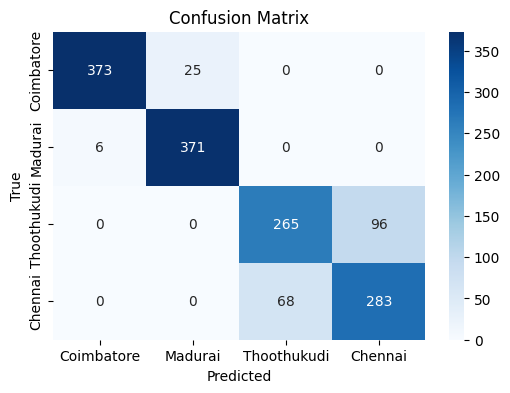

In [6]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Kannada

In [8]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract MFCC features from audio file and pad/truncate to a fixed length
def extract_features(file_path, mfcc_dim=39, max_len=300, hop_length=512, n_fft=480):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=mfcc_dim, hop_length=hop_length, n_fft=n_fft)
    
    # Pad or truncate mfcc to fixed length
    if mfcc.shape[1] > max_len:
        mfcc = mfcc[:, :max_len]
    else:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    
    return mfcc.T  # Transpose to have (time_steps, mfcc_dim)

# Function to load audio files and extract MFCC features
def load_data(data_dir, mfcc_dim=39, max_len=300, hop_length=512, n_fft=480):
    X = []
    y = []
    class_labels = {}
    class_index = 0

    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.wav'):  # Assuming audio files are in .wav format
                file_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                if label not in class_labels:
                    class_labels[label] = class_index
                    class_index += 1
                
                # Extract MFCC features and append to X
                mfcc = extract_features(file_path, mfcc_dim, max_len, hop_length, n_fft)
                X.append(mfcc)
                y.append(label)  # Append the actual label name here
    
    return np.array(X), np.array(y), class_labels

# Example usage
data_dir = '/dist_home/jairam/Kannada/'  
mfcc_dim = 39  # Updated MFCC coefficients
max_len = 300  # Desired length for MFCC sequences
nb_classes = 4  # Number of classes

# Load data
print('Loading data...')
X, y, class_labels = load_data(data_dir, mfcc_dim, max_len)

# Verify shapes
print('X shape:', X.shape)
print('y shape:', y.shape)
print('Number of classes:', len(class_labels))

# Print unique labels and their numeric values
unique_labels = np.unique(y)
for label in unique_labels:
    print(f"Label: {label}, Numeric Value: {class_labels[label]}")

# Convert labels to numeric format
y_numeric = np.array([class_labels[label] for label in y])

# Ensure labels are within the range 0 to nb_classes-1
assert np.min(y_numeric) >= 0 and np.max(y_numeric) < nb_classes, "Label values are out of range"

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.20, random_state=42)

# Convert class vectors to binary class matrices
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Build the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, stateful=False, input_shape=(max_len, mfcc_dim)))
model.add(LSTM(64, return_sequences=True, stateful=False))
model.add(LSTM(64, stateful=False))
model.add(Dropout(0.25))
model.add(Dense(nb_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Train the model
print("Training...")
history = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_data=(X_test, Y_test))

# Evaluate the model
score = model.evaluate(X_test, Y_test, batch_size=100, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Generate classification report
y_pred_prob = model.predict(X_test, batch_size=32)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=list(class_labels.keys())))


Loading data...
X shape: (8071, 300, 39)
y shape: (8071,)
Number of classes: 4
Label: Coastal, Numeric Value: 1
Label: Kundapura, Numeric Value: 0
Label: Mandhya, Numeric Value: 3
Label: North, Numeric Value: 2


/dist_home/common-apps/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 300, 64)        │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 300, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,932 (363.02 KB)

 Trainable params: 92,932 (363.02 KB)

 Non-trainable params: 0 (0.00 B)

Training...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3800 - loss: 1.2809 - val_accuracy: 0.5604 - val_loss: 1.0324
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5805 - loss: 0.9893 - val_accuracy: 0.6508 - val_loss: 0.8710
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6762 - loss: 0.8177 - val_accuracy: 0.7115 - val_loss: 0.7458
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7412 - loss: 0.6796 - val_accuracy: 0.7331 - val_loss: 0.7107
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7532 - loss: 0.6527 - val_accuracy: 0.7628 - val_loss: 0.6546
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7983 - loss: 0.5468 - val_accuracy: 0.7560 - val_loss: 0.6786
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8083 - loss: 0.5247 - val_accuracy: 0.7963 - val_loss: 0.6307
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7838 - loss: 0.5962 - val_accuracy

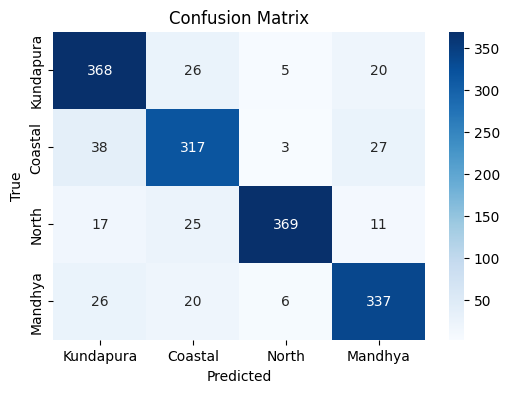

In [9]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()